# Hands-on Day 2

- course [slides](https://github.com/leggerf/MLCourse-INFN-2021/blob/master/Slides/Day2/Big%20data%20science%20-%20Day%202%20-%20INFN%202021.pdf)


## You'll learn

### ML methods

- Multilayer Perceptron Classifier (MCP) with pyspark.ml

### ML techniques

- hyperparameter optimisation
- ROC curves

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# our custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

# Data preprocessing

In [3]:
#inputFile = "s3a://scratch/legger/higgs/Higgs1M.parquet"
inputFile = "s3a://scratch/legger/higgs/Higgs100k.parquet"

%time df = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 13.2 ms, sys: 5.87 ms, total: 19.1 ms
Wall time: 11.7 s
There are 99999 events


In [4]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 80074
Events for validation 19925


In [5]:
# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

# Exercise 1

- Implement a shallow NN: use *MultiLayerPerceptronClassifier* from pyspark
- documentation: https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
- implement a network with: 
  - one input layer of size 28 (our features), 
  - two intermediate layers of size 30,
  - one output of size 2 (the label classes)
  - other hyerparameters: maxIter=100, blockSize=128, seed=1234
- plot the various metrics (ROC, signal vs background)
- bonus: do hyperparameter optimisation

In [6]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:

# input layer of size 28 (features), two intermediate of size 30, and output of size 2 (classes) - 30 minutes
layers = [28, 30, 30, 2]

# create the trainer and set its parameters
mpc = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)

In [7]:
%%time
model_mpc = mpc.fit(train)

CPU times: user 1.17 s, sys: 247 ms, total: 1.41 s
Wall time: 2min 37s


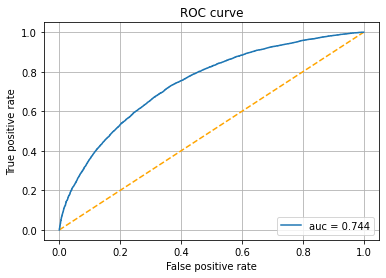

In [8]:
# compute accuracy on the test set
from pyspark.ml.evaluation import BinaryClassificationEvaluator

result = model_mpc.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
#print("Test set AUC = " + str(evaluator.evaluate(result)))

#make ROC curve
drawROC(result)

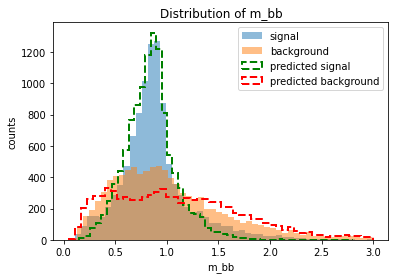

In [9]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

In [4]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()